In [26]:
#### This code is for ATOC7500 project 5 part I
#import modules
import numpy as np   #for calculations
import matplotlib.pyplot as plt  #for plotting
%matplotlib inline  
import pandas as pd  #for reading in data
import datetime    #for manipulation by dtae
import collections  #for additional dictionary functionality
from matplotlib.gridspec import GridSpec #for subplots
import scipy.signal as sig #for signal processing
import scipy.stats as stats
import xarray
import netCDF4 as nc

In [9]:
def create_normalized_redfit(data_length,Te):
    freq = np.arange(0,(data_length/2)+1,1)/float(data_length) # to Nyquist
    red_fit = (2 * Te)/(1 + ((2*np.pi*freq)**2)*(Te**2)) # After Hartmann 6.64, 6.91
    return red_fit/np.sum(red_fit)
def create_f_bounds(alpha,dof,red_fit_n):
    f_ratio = stats.f.ppf(alpha,dof,200) # Note: 200 = large degree of freedom for red noise
    return f_ratio*red_fit_n

In [3]:
## read in data
range1=1000   #for first 1000 years
nc_fid1=nc.Dataset('AMOC.nc')
data_origin=nc_fid1['amoc_timeseries_ann'][0:range1]
data_anom=data_origin-np.mean(data_origin)
print('length of first 1000 years is:', len(data_anom))

length of first 1000 years is: 1000


Text(0.5, 1.0, 'Annual Mean AMOC Strength Anomaly')

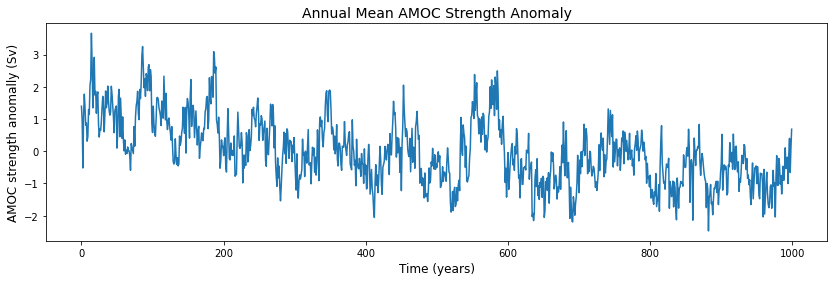

In [8]:
## plot data
fig = plt.figure(figsize=(14,4))
plt.xlabel('Time (years)',fontsize=12)
plt.ylabel('AMOC strength anomally (Sv)',fontsize=12)
plt.plot(data_anom)
plt.title('Annual Mean AMOC Strength Anomaly',fontsize=14)

lag-1 autocorrelation= 0.82 and Te = 5.12 years
   


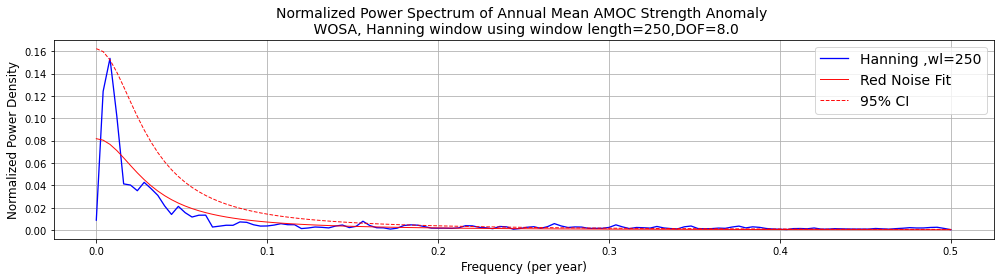

In [37]:
## get power spectra, Welch’s method (WOSA!) with a Hanning window and a window length of 250 years
# Calculate lag-1 autocorrelation and e-folding time of data
rho,lag1 = stats.pearsonr(data_anom[0:range1-1],data_anom[1:range1])
Te = -1./np.log(rho) # After Hartmann 6.4 with delta t = 1
print('lag-1 autocorrelation=',round(rho,2),'and Te =',round(Te,2),'years')
print('   ')

# get power spectra
window_length=250
T2 = window_length/2
freq_w = np.arange(0.,T2+1.)/window_length
P_welch = sig.welch(data_anom,window='hanning',nperseg=window_length);
P_welch_n = P_welch[1]/np.sum(P_welch[1])  #normalize

## Construct the expected rednoise spectrum - functions
## Need to update the 95% confidence interval
alpha = 0.95
red_fit_n_welch = create_normalized_redfit(window_length,Te)  ## generate red_fit_n using window_length
dof_welch=len(data_anom)/(window_length/2)  ### Barnes Eq. 26
f_bounds_welch = create_f_bounds(alpha,dof_welch,red_fit_n_welch)  ## f-test for variance; 


## plot
fig = plt.figure(figsize=(14,4))
plt.xlabel('Frequency (per year)',fontsize=12)
plt.ylabel('Normalized Power Density',fontsize=12)
plt.grid()
plt.plot(freq_w,P_welch_n, color='blue', lw=1.3, label='Hanning ,wl='+str(window_length));
plt.plot(freq_w,red_fit_n_welch, color='red', lw=1, alpha=0.95, label='Red Noise Fit');
plt.plot(freq_w,f_bounds_welch, color='red', lw=1, ls='--', alpha=0.95, label=str(int(alpha*100))+'% CI');
plt.title("Normalized Power Spectrum of Annual Mean AMOC Strength Anomaly \n WOSA, Hanning window using window length="+str(window_length)+",DOF="+str(round(dof_welch,0)),fontsize=14);
plt.legend(loc='upper right',fontsize=14)
fig.tight_layout()

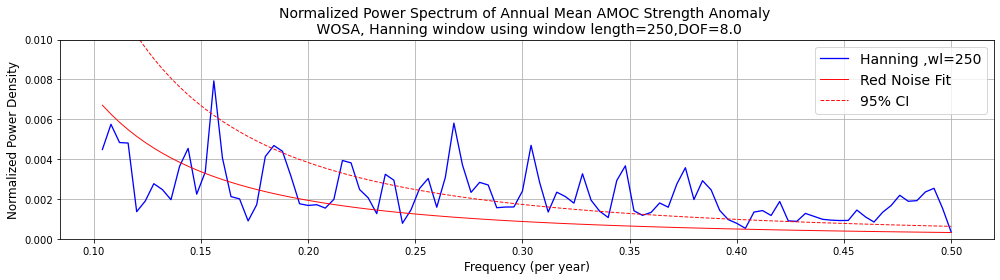

In [38]:
## plot higher frequency part
fig = plt.figure(figsize=(14,4))
plt.xlabel('Frequency (per year)',fontsize=12)
plt.ylabel('Normalized Power Density',fontsize=12)
plt.grid()
plt.ylim(0,0.01)
plt.plot(freq_w[26:126],P_welch_n[26:126], color='blue', lw=1.3, label='Hanning ,wl='+str(window_length));
plt.plot(freq_w[26:126],red_fit_n_welch[26:126], color='red', lw=1, alpha=0.95, label='Red Noise Fit');
plt.plot(freq_w[26:126],f_bounds_welch[26:126], color='red', lw=1, ls='--', alpha=0.95, label=str(int(alpha*100))+'% CI');
plt.title("Normalized Power Spectrum of Annual Mean AMOC Strength Anomaly \n WOSA, Hanning window using window length="+str(window_length)+",DOF="+str(round(dof_welch,0)),fontsize=14);
plt.legend(loc='upper right',fontsize=14)
fig.tight_layout()

In [22]:
## print peaks
print('finding peaks')
for i in range(len(P_welch_n[0:75])):
    if (P_welch_n[i] - f_bounds_welch[i]) > 5e-06:
        print('##### FOUND IT - spectral peak exceeds red noise ####')
        print('at frequency....',freq_w[i])
        print('which in years is approximately...',round((1/freq_w[i]))) ## use the regridded regular spacing   
        print('    ')
        print('    ')

finding peaks
##### FOUND IT - spectral peak exceeds red noise ####
at frequency.... 0.008
which in years is approximately... 125
    
    
##### FOUND IT - spectral peak exceeds red noise ####
at frequency.... 0.156
which in years is approximately... 6
    
    
##### FOUND IT - spectral peak exceeds red noise ####
at frequency.... 0.184
which in years is approximately... 5
    
    
##### FOUND IT - spectral peak exceeds red noise ####
at frequency.... 0.188
which in years is approximately... 5
    
    
##### FOUND IT - spectral peak exceeds red noise ####
at frequency.... 0.216
which in years is approximately... 5
    
    
##### FOUND IT - spectral peak exceeds red noise ####
at frequency.... 0.22
which in years is approximately... 5
    
    
##### FOUND IT - spectral peak exceeds red noise ####
at frequency.... 0.236
which in years is approximately... 4
    
    
##### FOUND IT - spectral peak exceeds red noise ####
at frequency.... 0.24
which in years is approximately... 4
    

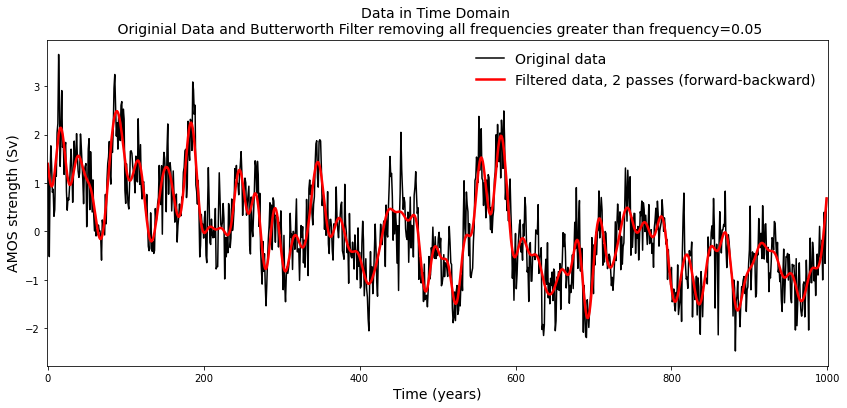

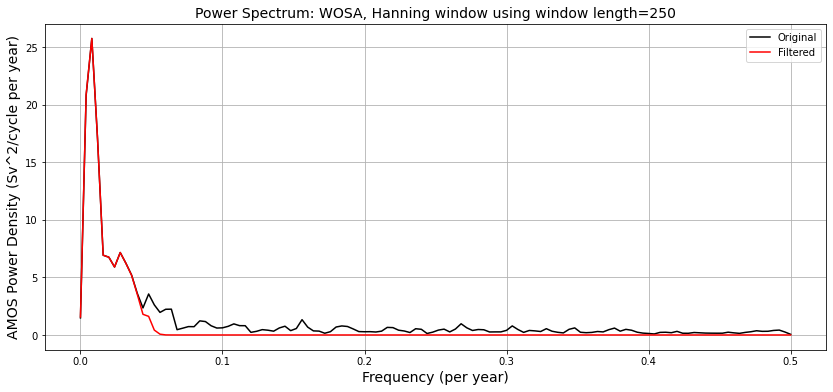

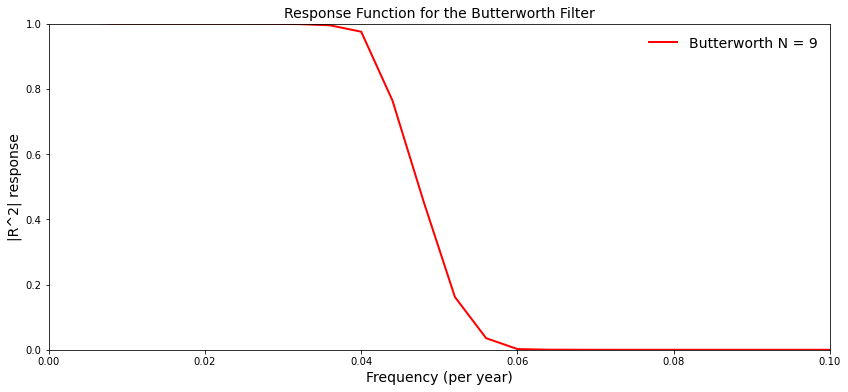

In [43]:
## Apply a Butterworth filter with N=9 (number of weights equal to 9) to remove frequencies greater than 0.05 per year 
frequency_cutoff=0.05
N = 9 ## order
Wn = frequency_cutoff*2 ## scalar given the critical frequency (all higher frequencies are removed)
## Note: Wn is normalized from 0 to 1, where 1 is the Nyquist frequency, pi radians/sample. 
## Note: (Wn is thus in half-cycles / sample.) 
b, a = sig.butter(N, Wn)
y = sig.filtfilt(b,a,data_anom) ## one filter forward, one filter backward 

### Calculate the power spectra - Hanning Window and WOSA (Welch’s Overlapping Segment Analysis)
P_welch_filt = sig.welch(y,window='hanning',nperseg=window_length);

### Calculate the response function of the butterworth filter using the convolution theorem
R2_bw=P_welch_filt[1]/P_welch[1]

## plot
fig = plt.figure(figsize=(14,6))
plt.xlabel('Time (years)',fontsize=14)
plt.ylabel('AMOS strength (Sv)',fontsize=14)
plt.plot(data_anom,'-k',linewidth = 1.5, label = 'Original data');
plt.plot(y,'-r',linewidth = 2.5, label = 'Filtered data, 2 passes (forward-backward)');
plt.title('Data in Time Domain \n Originial Data and Butterworth Filter removing all frequencies greater than frequency='+str(frequency_cutoff),fontsize=14)
plt.legend(frameon = False,fontsize = 14,loc='upper right')
plt.xlim(-1,np.size(data)+1)

fig = plt.figure(figsize=(14,6))
plt.xlabel('Frequency (per year)',fontsize=14)
plt.ylabel('AMOS Power Density (Sv^2/cycle per year)',fontsize=14) 
plt.grid()
plt.plot(freq_w,P_welch[1],'-k',lw=1.5, label='Original');
plt.plot(freq_w,P_welch_filt[1],'-r',lw=1.5, label='Filtered');
plt.legend(loc='upper right')
plt.title("Power Spectrum: WOSA, Hanning window using window length="+str(window_length),fontsize=14);

fig = plt.figure(figsize=(14,6))
plt.plot(freq_w,R2_bw,'-r',linewidth = 2, label = 'Butterworth N = '+str(N));
plt.xlabel('Frequency (per year)',fontsize=14);
plt.ylabel('|R^2| response',fontsize=14);
plt.legend(fontsize = 14, frameon = False);
plt.title('Response Function for the Butterworth Filter',fontsize=14)
plt.ylim(0.0,1.0);
plt.xlim(0.0,0.10); 